# **Trabajo Práctico - Aprendizaje Automático**
# *Integrante: Lucas Demarré*
# *Año: 2023*

## **Importamos los bibliotecas necesarias y cargamos el dataset**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

 ## **Realizamos un análisis descriptivo**.

### Cargamos el dataset

In [ ]:
# Cargar el conjunto de datos
data = pd.read_csv("weatherAUS.csv")
data.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


### Filtramos solo las ciudades que nos interesan

In [ ]:
# Creamos una lista con las ubicaciones de interés
ubicaciones_interes = ['Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport']

# Filtramos el dataset para incluir solo las ubicaciones de interés
data = data[data['Location'].isin(ubicaciones_interes)]

# Restablecemos el índice del DataFrame después de la filtración
data.reset_index(drop=True, inplace=True)

data.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,30176,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,...,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,Yes,6.0
1,30177,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,...,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,Yes,6.6
2,30178,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,...,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,Yes,18.8
3,30179,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,...,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,Yes,77.4
4,30180,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,...,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,Yes,1.6


### Detectamos si hay datos faltantes


In [ ]:
# Calculamos los datos faltantes y los tipos de datos
missing_data = data.isnull().sum()
types = data.dtypes

# Combinamos los resultados en un DataFrame
info = pd.concat([missing_data, types], axis=1)
info.columns = ['Datos Faltantes', 'Tipo de Dato']

# Mostramos el DataFrame
print(info)

                  Datos Faltantes Tipo de Dato
Unnamed: 0                      0        int64
Date                            0       object
Location                        0       object
MinTemp                       491      float64
MaxTemp                       486      float64
Rainfall                      787      float64
Evaporation                  1706      float64
Sunshine                     1948      float64
WindGustDir                  1457       object
WindGustSpeed                1455      float64
WindDir9am                    695       object
WindDir3pm                    290       object
WindSpeed9am                  261      float64
WindSpeed3pm                  249      float64
Humidity9am                   570      float64
Humidity3pm                   525      float64
Pressure9am                   735      float64
Pressure3pm                   726      float64
Cloud9am                     2677      float64
Cloud3pm                     2932      float64
Temp9am      

#### *Solucionamos los datos faltantes numéricos:*

In [ ]:
# Encontramos las columnas numéricas con datos faltantes
columnas_numericas_con_faltantes = data.select_dtypes(include=['number']).columns[data.select_dtypes(include=['number']).isna().any()]

# Reemplazamos los valores faltantes con la mediana solo en las columnas seleccionadas
data[columnas_numericas_con_faltantes] = data[columnas_numericas_con_faltantes].fillna(data[columnas_numericas_con_faltantes].median())

# Visualizamos los datos faltantes
missing_data = data.isnull().sum()
print(missing_data)

Unnamed: 0             0
Date                   0
Location               0
MinTemp                0
MaxTemp                0
Rainfall               0
Evaporation            0
Sunshine               0
WindGustDir         1457
WindGustSpeed          0
WindDir9am           695
WindDir3pm           290
WindSpeed9am           0
WindSpeed3pm           0
Humidity9am            0
Humidity3pm            0
Pressure9am            0
Pressure3pm            0
Cloud9am               0
Cloud3pm               0
Temp9am                0
Temp3pm                0
RainToday            787
RainTomorrow         787
RainfallTomorrow       0
dtype: int64


<ipython-input-5-27dab43d30b6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columnas_numericas_con_faltantes] = data[columnas_numericas_con_faltantes].fillna(data[columnas_numericas_con_faltantes].median())


#### *Solucionamos los datos faltantes categóricos:*

In [ ]:
# Identificamos las columnas categóricas y con datos faltantes
columnas_categoricas_con_faltantes = list(missing_data[missing_data > 0].index)
columnas_categoricas = [col for col in columnas_categoricas_con_faltantes if types[col] == 'object']

# Reemplazamos los valores faltantes con la moda en las columnas categóricas
for columna in columnas_categoricas:
    moda = data[columna].mode()[0]
    data[columna].fillna(moda, inplace=True)

# Visualizamos los datos faltantes
missing_data = data.isnull().sum()
print(missing_data)

Unnamed: 0          0
Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
RainfallTomorrow    0
dtype: int64


<ipython-input-6-f0192a392dd6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columna].fillna(moda, inplace=True)
<ipython-input-6-f0192a392dd6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columna].fillna(moda, inplace=True)


### Visualización de datos

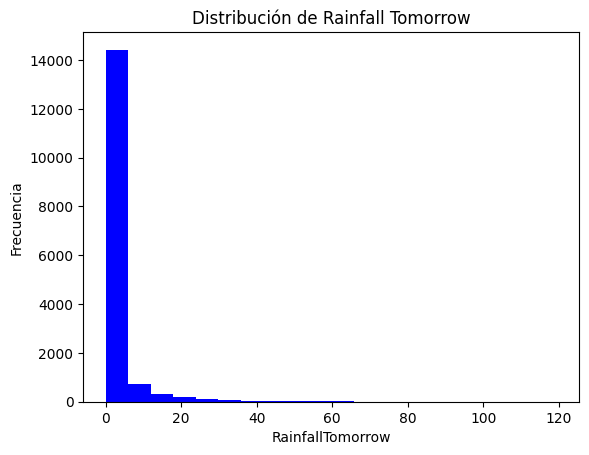

In [ ]:
# Ejemplo de un histograma para la columna "Rainfall"
plt.hist(data['Rainfall'], bins=20, color='blue')
plt.xlabel('RainfallTomorrow')
plt.ylabel('Frecuencia')
plt.title('Distribución de Rainfall Tomorrow')
plt.show()

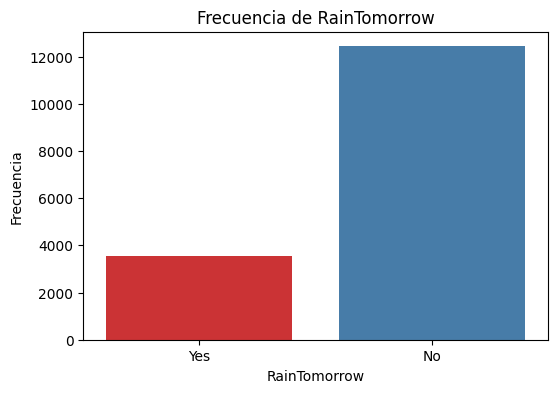

In [ ]:
# Creamos un gráfico de barras para la columna 'RainTomorrow'
plt.figure(figsize=(6, 4))
sns.countplot(x='RainTomorrow', data=data, palette='Set1')
plt.xlabel('RainTomorrow')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de RainTomorrow')
plt.show()

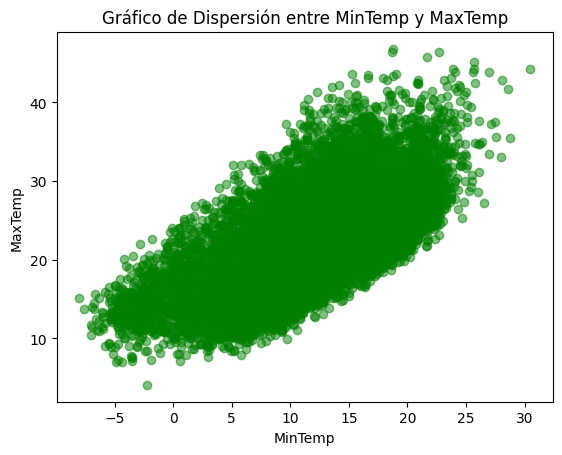

In [ ]:
# Ejemplo de un gráfico de dispersión entre "MinTemp" y "MaxTemp"
plt.scatter(data['MinTemp'], data['MaxTemp'], color='green', alpha=0.5)
plt.xlabel('MinTemp')
plt.ylabel('MaxTemp')
plt.title('Gráfico de Dispersión entre MinTemp y MaxTemp')
plt.show()

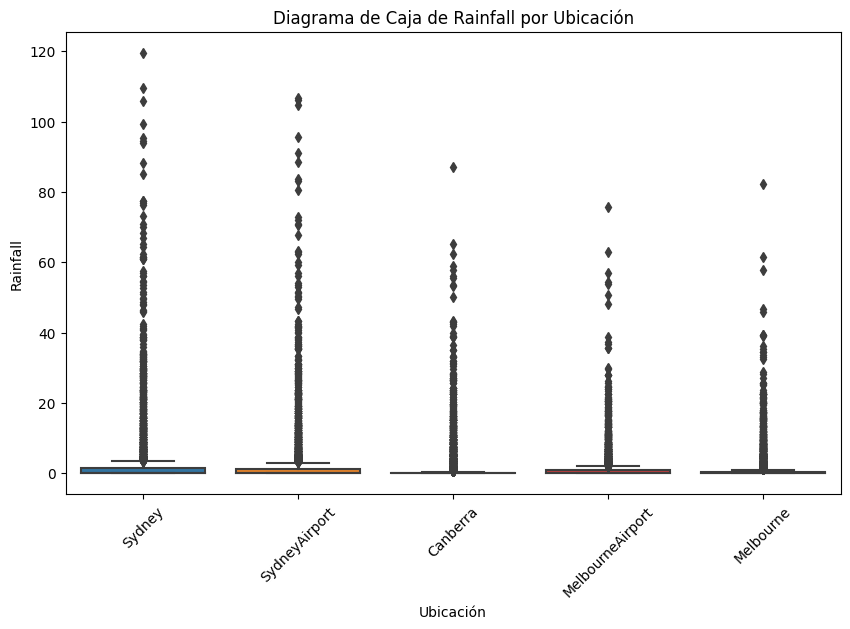

In [ ]:
# Ejemplo de un diagrama de caja para "Rainfall" por ubicación
plt.figure(figsize=(10, 6))
sns.boxplot(x='Location', y='Rainfall', data=data)
plt.xlabel('Ubicación')
plt.ylabel('Rainfall')
plt.title('Diagrama de Caja de Rainfall por Ubicación')
plt.xticks(rotation=45)  # Rotar las etiquetas en el eje X para una mejor legibilidad
plt.show()

In [ ]:
data.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,30176,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,N,43.0,...,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,Yes,6.0
1,30177,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,N,43.0,...,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,Yes,6.6
2,30178,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,N,43.0,...,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,Yes,18.8
3,30179,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,N,43.0,...,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,Yes,77.4
4,30180,2008-02-05,Sydney,19.7,25.7,77.4,4.2,0.0,N,43.0,...,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,Yes,1.6


In [ ]:
rain_tomorrow_counts = data['RainTomorrow'].value_counts()
print("Equilibrio de RainTomorrow:")
print(rain_tomorrow_counts)

Equilibrio de RainTomorrow:
No     12430
Yes     3556
Name: RainTomorrow, dtype: int64


In [ ]:
rainfall_tomorrow_counts = data['RainfallTomorrow'].value_counts()
print("Equilibrio de RainfallTomorrow:")
print(rainfall_tomorrow_counts)

Equilibrio de RainfallTomorrow:
0.0      10486
0.2        842
0.4        412
0.6        306
0.8        192
         ...  
76.4         1
49.4         1
95.2         1
54.0         1
109.4        1
Name: RainfallTomorrow, Length: 286, dtype: int64


In [ ]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Balancear 'RainTomorrow' (undersampling)
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_rain_tomorrow = data.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1)
y_rain_tomorrow = data['RainTomorrow']
X_resampled_rain_tomorrow, y_resampled_rain_tomorrow = undersampler.fit_resample(X_rain_tomorrow, y_rain_tomorrow)

# Verificar el nuevo equilibrio de las variables
print("Equilibrio de RainTomorrow después del balanceo:")
print(y_resampled_rain_tomorrow.value_counts())

Equilibrio de RainTomorrow después del balanceo:
No     3556
Yes    3556
Name: RainTomorrow, dtype: int64


### Escalamos los datos

In [ ]:
data.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,30176,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,N,43.0,...,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,Yes,6.0
1,30177,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,N,43.0,...,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,Yes,6.6
2,30178,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,N,43.0,...,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,Yes,18.8
3,30179,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,N,43.0,...,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,Yes,77.4
4,30180,2008-02-05,Sydney,19.7,25.7,77.4,4.2,0.0,N,43.0,...,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,Yes,1.6


In [ ]:
# Seleccionamos las columnas numéricas para normalizar
numeric_columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed',
                   'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
                   'Temp9am', 'Temp3pm', 'RainfallTomorrow']

# Creamos una instancia de StandardScaler
scaler = StandardScaler()

# Aplicamos el escalado a las columnas numéricas
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

In [ ]:
data.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,30176,2008-02-01,Sydney,1.370506,0.111043,1.857584,0.482815,-1.922316,N,-0.090304,...,1.877997,-0.098882,0.186669,1.200401,1.265206,0.942967,0.118641,Yes,Yes,0.527944
1,30177,2008-02-02,Sydney,1.370506,0.647842,0.527737,-0.479835,-1.173721,N,-0.090304,...,1.246808,-0.057379,0.045792,0.805561,0.846803,1.253716,0.794943,Yes,Yes,0.611068
2,30178,2008-02-03,Sydney,1.735052,0.463317,0.610853,-0.823638,-1.894590,N,-0.090304,...,1.992759,-0.223389,-0.066909,0.805561,1.265206,1.454788,0.482803,Yes,Yes,2.301253
3,30179,2008-02-04,Sydney,1.492022,0.178143,2.300866,-0.892399,-1.922316,N,-0.090304,...,2.222282,-0.569244,-0.602238,1.200401,1.265206,1.070923,0.118641,Yes,Yes,10.419687
4,30180,2008-02-05,Sydney,1.405225,0.664617,10.418470,-0.204792,-1.922316,N,-0.090304,...,1.304188,-1.385461,-1.588372,1.200401,1.265206,1.271995,0.916330,Yes,Yes,-0.081632


### Codificación de variable categórica

In [ ]:
# Verificamos las categorías únicas en la columna 'RainTomorrow'
print(data['RainTomorrow'].unique())

['Yes' 'No']


In [ ]:
# Codificamos de 'RainTomorrow': 'Yes' a 1, 'No' a 0
data['RainTomorrow'] = data['RainTomorrow'].map({'Yes': 1, 'No': 0})

In [ ]:
# Mostramos estadísticas descriptivas para la columna 'RainTomorrow'
rain_tomorrow_stats = data['RainTomorrow'].describe()
print(rain_tomorrow_stats)

count    15986.000000
mean         0.222445
std          0.415901
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: RainTomorrow, dtype: float64


### Matriz de Correlación y elección de características

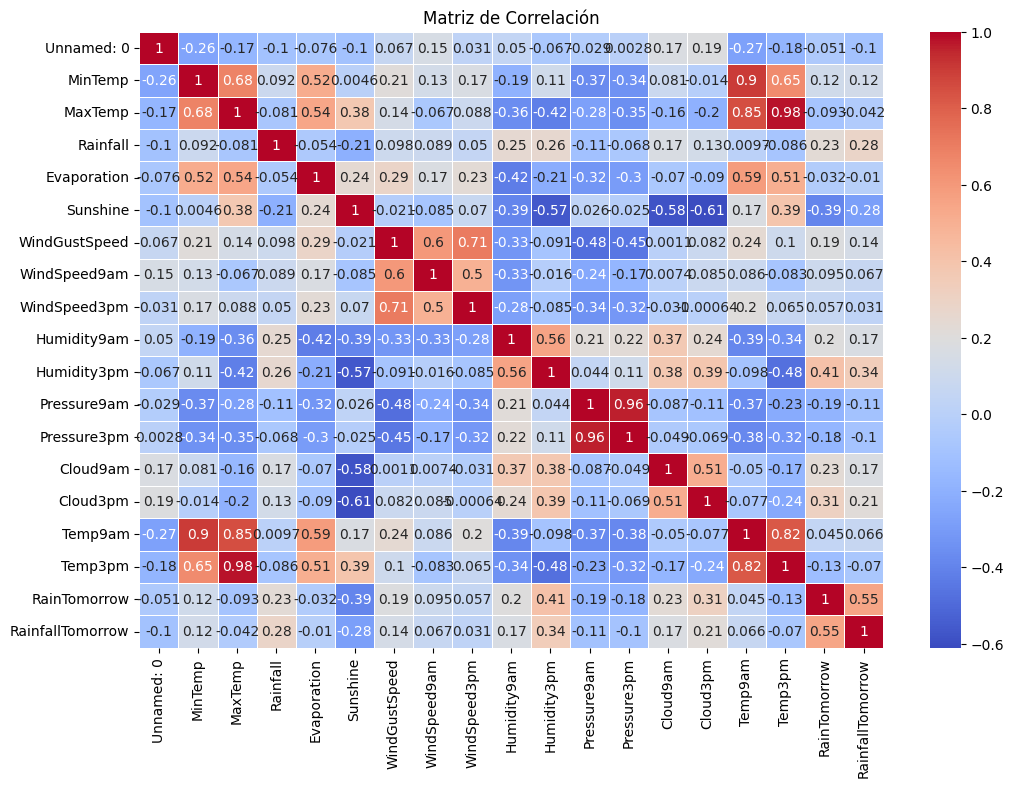

In [ ]:
# Seleccionamos las variables numéricas para la matriz de correlación
variables_numericas = data.select_dtypes(include='number')

# Calculamos la matriz de correlación
correlation_matrix = variables_numericas.corr()

# Creamos una visualización de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

Vamos a mirar únicamente las dos últimas filas que pertenecen a las variables a predecir. Vemos que las siguientes características tienen una correlación de, al menos, 0.2 en alguna de las variables a predecir: "Rainfall", "Humidity 9am", "Humidity 3pm", "Cloud 9am", "Cloud 3pm". Por lo tanto, estas van a ser las características elegidas para la predicción.

### Estandarización

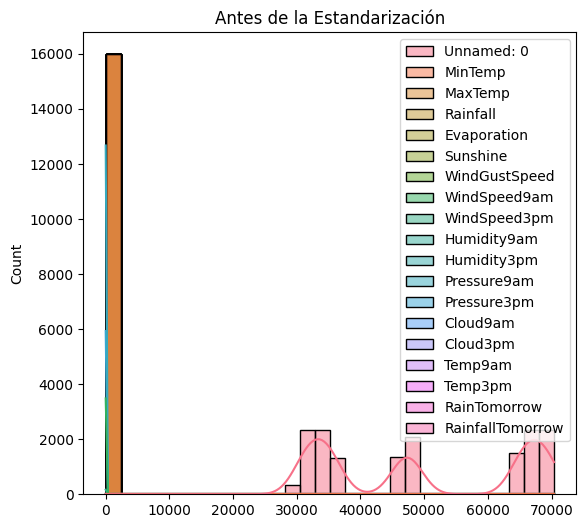

In [ ]:
# Seleccionamos solo las características numéricas para el gráfico
numeric_features = data.select_dtypes(include='number')

# Creamos un gráfico antes de la estandarización
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=numeric_features, bins=30, kde=True)
plt.title("Antes de la Estandarización")

# Creamos una instancia del StandardScaler
scaler = StandardScaler()

# Ajustamos el escalador a las características numéricas
scaler.fit(numeric_features)

# Estandarizamos las características numéricas
numeric_features_estandarizado = scaler.transform(numeric_features)

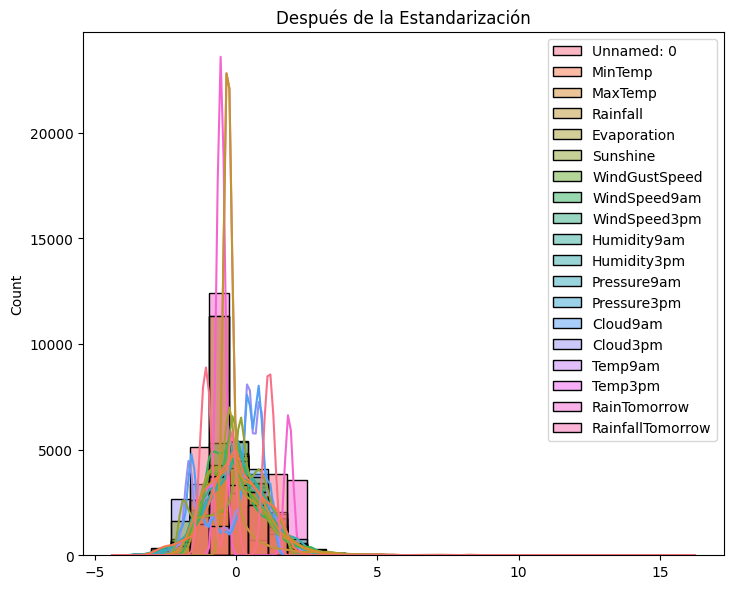

In [ ]:
# Convertimos el resultado de la estandarización en un DataFrame
numeric_features_estandarizado = pd.DataFrame(numeric_features_estandarizado, columns=numeric_features.columns)

# Creamos un gráfico después de la estandarización
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)
sns.histplot(data=numeric_features_estandarizado, bins=30, kde=True)
plt.title("Después de la Estandarización")

plt.tight_layout()
plt.show()

In [ ]:
numeric_features_estandarizado.head()

,Unnamed: 0,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow,RainfallTomorrow
0,-1.274500,1.370506,0.111043,1.857584,0.482815,-1.922316,-0.090304,0.040248,-0.187295,1.503637,1.877997,-0.098882,0.186669,1.200401,1.265206,0.942967,0.118641,1.869626,0.527944
1,-1.274434,1.370506,0.647842,0.527737,-0.479835,-1.173721,-0.090304,-0.739983,-0.928354,0.916734,1.246808,-0.057379,0.045792,0.805561,0.846803,1.253716,0.794943,1.869626,0.611068
2,-1.274368,1.735052,0.463317,0.610853,-0.823638,-1.894590,-0.090304,0.040248,-2.092876,1.242791,1.992759,-0.223389,-0.066909,0.805561,1.265206,1.454788,0.482803,1.869626,2.301253
3,-1.274302,1.492022,0.178143,2.300866,-0.892399,-1.922316,-0.090304,0.527892,-0.187295,0.916734,2.222282,-0.569244,-0.602238,1.200401,1.265206,1.070923,0.118641,1.869626,10.419687
4,-1.274236,1.405225,0.664617,10.418470,-0.204792,-1.922316,-0.090304,-0.544926,-1.669413,1.242791,1.304188,-1.385461,-1.588372,1.200401,1.265206,1.271995,0.916330,1.869626,-0.081632


 ## **Implementamos la solución del problema de regresión con regresión lineal múltiple**

In [ ]:
# Seleccionamos solo las columnas deseadas
selected_features = ["Rainfall", "Humidity9am", "Humidity3pm", "Cloud9am", "Cloud3pm"]

### Método LinearRegression

In [ ]:
# Seleccionamos solo las columnas deseadas
X = data[selected_features]
y1 = data['RainTomorrow']  # Primera variable objetivo
y2 = data['RainfallTomorrow']  # Segunda variable objetivo

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.2, random_state=42)

# Creamos una instancia del modelo de regresión lineal para la primera variable objetivo
model1 = LinearRegression()

# Entrenamos el modelo con los datos de entrenamiento para la primera variable objetivo
model1.fit(X_train, y1_train)

# Realizamos predicciones en los datos de prueba para la primera variable objetivo
y1_pred = model1.predict(X_test)

# Calculamos el coeficiente de determinación (R2 Score) para la primera variable objetivo
r2_1 = r2_score(y1_test, y1_pred)

# Calculamos el Error Cuadrático Medio (MSE) para la primera variable objetivo
mse_1 = mean_squared_error(y1_test, y1_pred)

# Calculamos el Error Absoluto Medio (MAE) para la primera variable objetivo
mae_1 = mean_absolute_error(y1_test, y1_pred)

# Repetimos para la segunda variable objetivo
model2 = LinearRegression()
model2.fit(X_train, y2_train)
y2_pred = model2.predict(X_test)
r2_2 = r2_score(y2_test, y2_pred)
mse_2 = mean_squared_error(y2_test, y2_pred)
mae_2 = mean_absolute_error(y2_test, y2_pred)

# Imprimimos las métricas
print("Métricas para la primera variable objetivo:")
print("Coeficiente de Determinación (R2 Score):", r2_1)
print("Error Cuadrático Medio (MSE):", mse_1)
print("Error Absoluto Medio (MAE):", mae_1)
print()

print("Métricas para la segunda variable objetivo:")
print("Coeficiente de Determinación (R2 Score):", r2_2)
print("Error Cuadrático Medio (MSE):", mse_2)
print("Error Absoluto Medio (MAE):", mae_2)

Métricas para la primera variable objetivo:
Coeficiente de Determinación (R2 Score): 0.2320308170440608
Error Cuadrático Medio (MSE): 0.13748356571028406
Error Absoluto Medio (MAE): 0.2897093166150385

Métricas para la segunda variable objetivo:
Coeficiente de Determinación (R2 Score): 0.20440531334662515
Error Cuadrático Medio (MSE): 0.9434629715170698
Error Absoluto Medio (MAE): 0.44633857245058484


### Métodos de Gradiente Descendiente

#### Gradiente Decendiente

##### Función

In [ ]:
def gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_test = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))


    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de test')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

##### Implementación

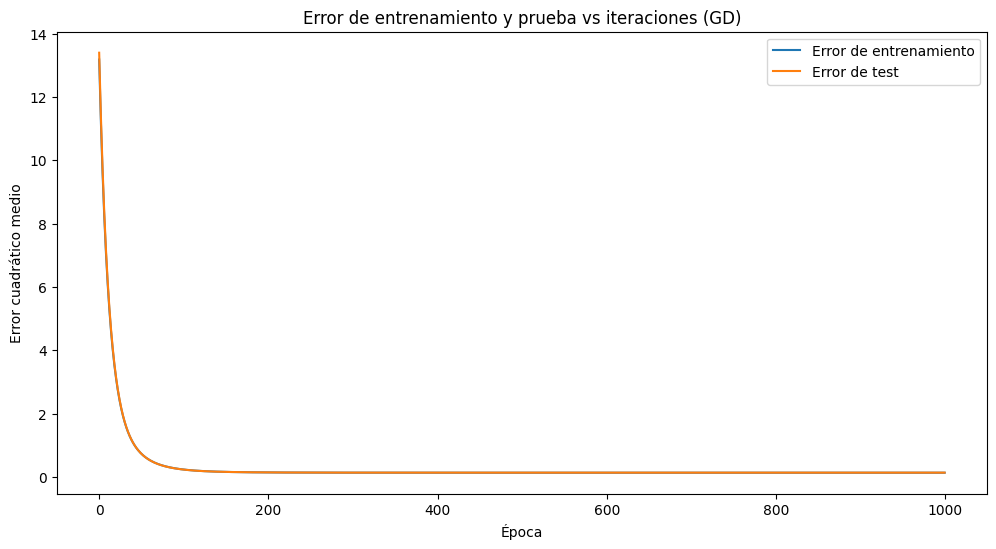

Métricas para RainTomorrow:
R2 Score: 0.23205022585880042
MSE: 0.13748009110073484
RMSE: 0.3707830782286792
MAE: 0.28970181953877355
MAPE: 60.30186866932304


In [ ]:
# Usamos los datos de las características seleccionadas
X = data[selected_features]
y1 = data['RainTomorrow'].values.reshape(-1, 1)

# Separamos los datos en conjuntos de entrenamiento y prueba para RainTomorrow
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamos el modelo de gradiente descendente para RainTomorrow
W1 = gradient_descent(X_train_scaled, y1_train, X_test_scaled, y1_test, lr=0.01, epochs=1000)

# Función para calcular MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    # Verificamos si hay ceros en y_true y ajustar según corresponda
    mask = y_true != 0
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]

    # Calculamos MAPE solo para las observaciones donde y_true no es cero
    if len(y_true_masked) > 0:
        mape = np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked)) * 100
    else:
        mape = 0  # Si no hay observaciones válidas, se establece MAPE en cero.

    return mape

# Calculamos las métricas para el modelo de RainTomorrow
y1_pred = np.matmul(np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled)), W1)

r2_1 = r2_score(y1_test, y1_pred)
mse_1 = mean_squared_error(y1_test, y1_pred)
rmse_1 = math.sqrt(mse_1)
mae_1 = mean_absolute_error(y1_test, y1_pred)
mape_1 = mean_absolute_percentage_error(y1_test, y1_pred)

print("Métricas para RainTomorrow:")
print("R2 Score:", r2_1)
print("MSE:", mse_1)
print("RMSE:", rmse_1)
print("MAE:", mae_1)
print("MAPE:", mape_1)

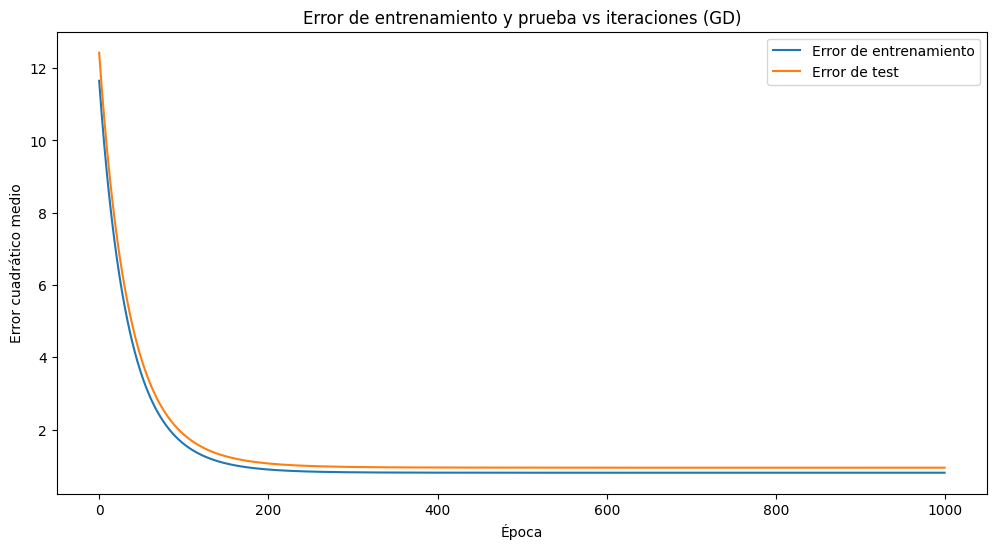


Métricas para RainfallTomorrow:
R2 Score: 0.20439021080023367
MSE: 0.9434808810048216
RMSE: 0.9713294399969671
MAE: 0.44630089218200775
MAPE: 265.6871329513466


In [ ]:
# Usamos los datos de las características seleccionadas
X = data[selected_features]
y2 = data['RainfallTomorrow'].values.reshape(-1, 1)

# Separamos los datos en conjuntos de entrenamiento y prueba para RainfallTomorrow
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)

# Entrenamos el modelo de gradiente descendente para RainfallTomorrow
W2 = gradient_descent(X_train_scaled, y2_train, X_test_scaled, y2_test, lr=0.01, epochs=1000)

# Función para calcular MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    # Verificar si hay ceros en y_true y ajustar según corresponda
    mask = y_true != 0
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]

    # Calcular MAPE solo para las observaciones donde y_true no es cero
    if len(y_true_masked) > 0:
        mape = np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked)) * 100
    else:
        mape = 0  # Si no hay observaciones válidas, se establece MAPE en cero.

    return mape

# Calculamos las métricas para el modelo de RainfallTomorrow
y2_pred = np.matmul(np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled)), W2)

r2_2 = r2_score(y2_test, y2_pred)
mse_2 = mean_squared_error(y2_test, y2_pred)
rmse_2 = math.sqrt(mse_2)
mae_2 = mean_absolute_error(y2_test, y2_pred)
mape_2 = mean_absolute_percentage_error(y2_test, y2_pred)

print("\nMétricas para RainfallTomorrow:")
print("R2 Score:", r2_2)
print("MSE:", mse_2)
print("RMSE:", rmse_2)
print("MAE:", mae_2)
print("MAPE:", mape_2)

#### Gradiente descenciente estocástico

##### Función

In [ ]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

##### Implementación

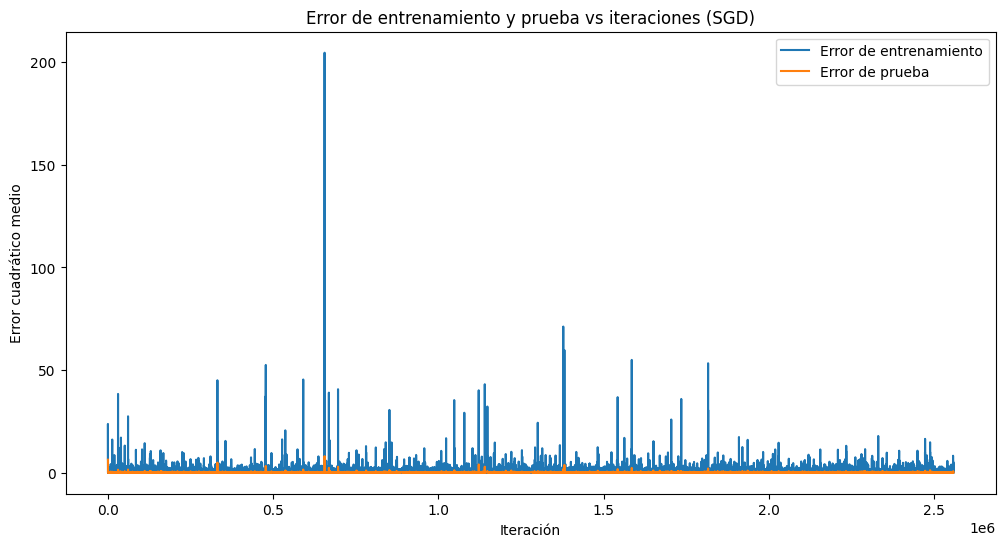

Métricas para RainTomorrow (SGD):
R2 Score: 0.11842739551711712
MSE: 0.15782110504786026
RMSE: 0.3972670450060768
MAE: 0.3157761719212737
MAPE: 61.038080409300534


In [ ]:
# Usamos los datos de las características seleccionadas
X = data[selected_features]
y1 = data['RainTomorrow'].values.reshape(-1, 1)

# Separamos los datos en conjuntos de entrenamiento y prueba para RainTomorrow
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamos el modelo de SGD para RainTomorrow
W1_sgd = stochastic_gradient_descent(X_train_scaled, y1_train, X_test_scaled, y1_test, lr=0.01, epochs=200)

# Calculamos las métricas para el modelo de RainTomorrow
y1_pred_sgd = np.matmul(np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled)), W1_sgd)

r2_1_sgd = r2_score(y1_test, y1_pred_sgd)
mse_1_sgd = mean_squared_error(y1_test, y1_pred_sgd)
rmse_1_sgd = math.sqrt(mse_1_sgd)
mae_1_sgd = mean_absolute_error(y1_test, y1_pred_sgd)
mape_1_sgd = mean_absolute_percentage_error(y1_test, y1_pred_sgd)

print("Métricas para RainTomorrow (SGD):")
print("R2 Score:", r2_1_sgd)
print("MSE:", mse_1_sgd)
print("RMSE:", rmse_1_sgd)
print("MAE:", mae_1_sgd)
print("MAPE:", mape_1_sgd)

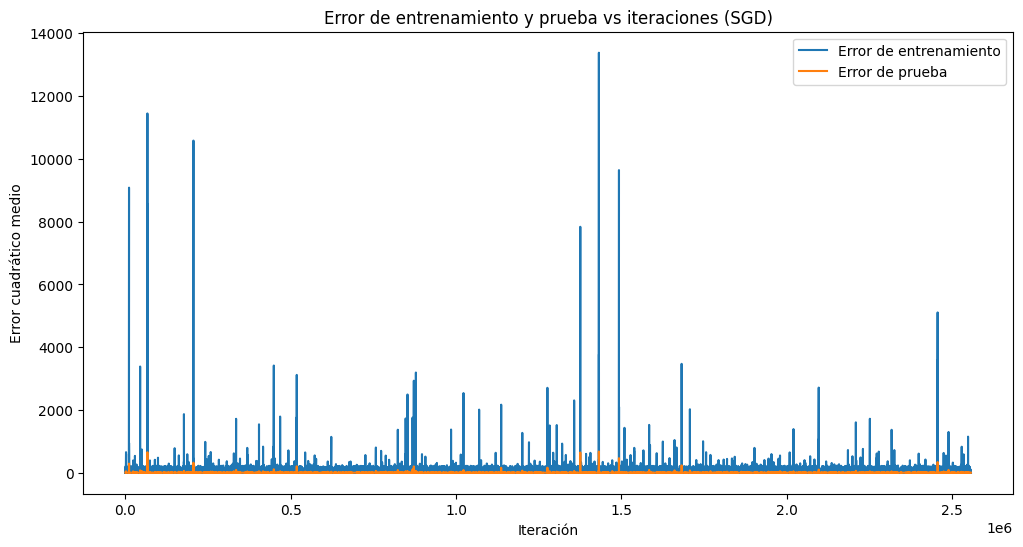


Métricas para RainfallTomorrow (SGD):
R2 Score: 0.1461210511361506
MSE: 1.012579877575207
RMSE: 1.006270280578338
MAE: 0.3972251923528449
MAPE: 168.58143183685613


In [ ]:
# Usamos los datos de las características seleccionadas
X = data[selected_features]
y2 = data['RainfallTomorrow'].values.reshape(-1, 1)

# Separamos los datos en conjuntos de entrenamiento y prueba para RainfallTomorrow
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamos el modelo de SGD para RainfallTomorrow
W2_sgd = stochastic_gradient_descent(X_train_scaled, y2_train, X_test_scaled, y2_test, lr=0.01, epochs=200)

# Calculamos las métricas para el modelo de RainfallTomorrow
y2_pred_sgd = np.matmul(np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled)), W2_sgd)

r2_2_sgd = r2_score(y2_test, y2_pred_sgd)
mse_2_sgd = mean_squared_error(y2_test, y2_pred_sgd)
rmse_2_sgd = math.sqrt(mse_2_sgd)
mae_2_sgd = mean_absolute_error(y2_test, y2_pred_sgd)
mape_2_sgd = mean_absolute_percentage_error(y2_test, y2_pred_sgd)

print("\nMétricas para RainfallTomorrow (SGD):")
print("R2 Score:", r2_2_sgd)
print("MSE:", mse_2_sgd)
print("RMSE:", rmse_2_sgd)
print("MAE:", mae_2_sgd)
print("MAPE:", mape_2_sgd)

#### Gradiente descendiente mini-batch

##### Función

In [ ]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):

        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

##### Implementación

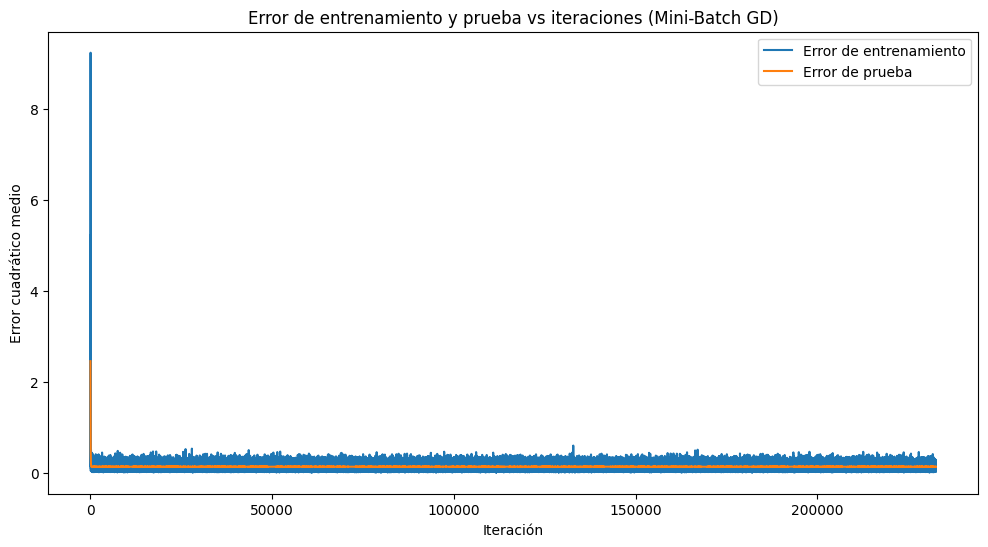

Métricas para RainTomorrow (Mini-Batch Gradient Descent):
R2 Score: 0.22959029970260536
MSE: 0.13792047259890375
RMSE: 0.3713764567105779
MAE: 0.29138060190656845
MAPE: 57.537245635714974


In [ ]:
# Usamos los datos de las características seleccionadas
X = data[selected_features]
y1 = data['RainTomorrow'].values.reshape(-1, 1)

# Separamos los datos en conjuntos de entrenamiento y prueba para RainTomorrow
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamos el modelo de SGD para RainTomorrow
W1_mbgd = mini_batch_gradient_descent(X_train_scaled, y1_train, X_test_scaled, y1_test, lr=0.01, epochs=200)

# Calculamos las métricas para el modelo de RainTomorrow
y1_pred_mbgd = np.matmul(np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled)), W1_mbgd)

r2_1_mbgd = r2_score(y1_test, y1_pred_mbgd)
mse_1_mbgd = mean_squared_error(y1_test, y1_pred_mbgd)
rmse_1_mbgd = math.sqrt(mse_1_mbgd)
mae_1_mbgd = mean_absolute_error(y1_test, y1_pred_mbgd)
mape_1_mbgd = mean_absolute_percentage_error(y1_test, y1_pred_mbgd)

print("Métricas para RainTomorrow (Mini-Batch Gradient Descent):")
print("R2 Score:", r2_1_mbgd)
print("MSE:", mse_1_mbgd)
print("RMSE:", rmse_1_mbgd)
print("MAE:", mae_1_mbgd)
print("MAPE:", mape_1_mbgd)

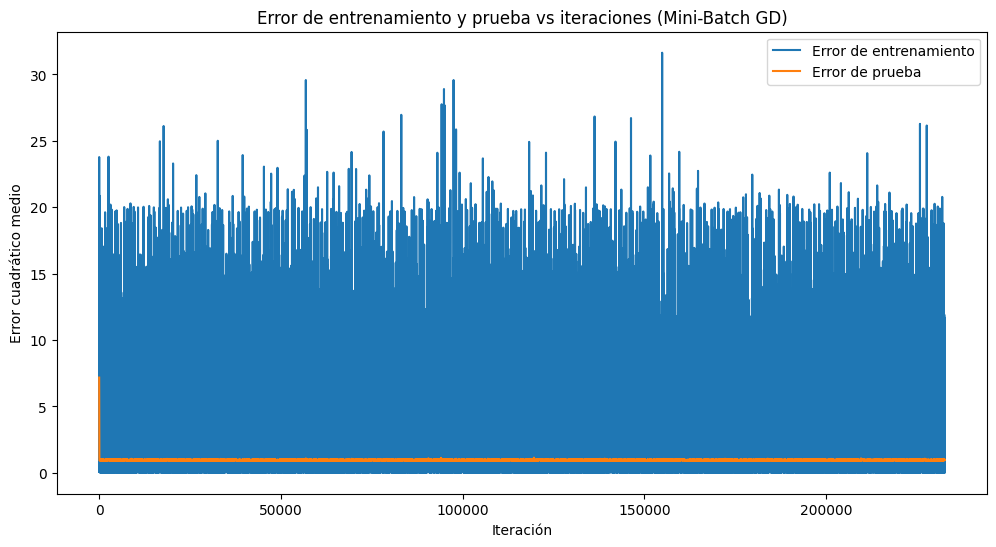

Métricas para RainfallTomorrow (Mini-Batch Gradient Descent):
R2 Score: 0.18411174363362848
MSE: 0.967528280028179
RMSE: 0.9836301540864733
MAE: 0.42225477288028396
MAPE: 219.31752698177837


In [ ]:
# Usamos los datos de las características seleccionadas
X = data[selected_features]
y2 = data['RainfallTomorrow'].values.reshape(-1, 1)

# Separamos los datos en conjuntos de entrenamiento y prueba para RainfallTomorrow
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamos el modelo de SGD para RainfallTomorrow
W2_mbgd = mini_batch_gradient_descent(X_train_scaled, y2_train, X_test_scaled, y2_test, lr=0.01, epochs=200)

# Calculamos las métricas para el modelo de RainfallTomorrow entrenado con Mini-Batch Gradient Descent (W2_mbgd)
y2_pred_mbgd = np.matmul(np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled)), W2_mbgd)

r2_2_mbgd = r2_score(y2_test, y2_pred_mbgd)
mse_2_mbgd = mean_squared_error(y2_test, y2_pred_mbgd)
rmse_2_mbgd = math.sqrt(mse_2_mbgd)
mae_2_mbgd = mean_absolute_error(y2_test, y2_pred_mbgd)
mape_2_mbgd = mean_absolute_percentage_error(y2_test, y2_pred_mbgd)

print("Métricas para RainfallTomorrow (Mini-Batch Gradient Descent):")
print("R2 Score:", r2_2_mbgd)
print("MSE:", mse_2_mbgd)
print("RMSE:", rmse_2_mbgd)
print("MAE:", mae_2_mbgd)
print("MAPE:", mape_2_mbgd)

### Regularización

In [ ]:
# Seleccionamos solo las columnas deseadas
X = data[selected_features]
y1 = data['RainTomorrow']

# Separamos los datos en conjuntos de entrenamiento y prueba para RainTomorrow
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)

# Creamos instancias de los modelos de regularización
lasso_model = Lasso(alpha=1.0)
ridge_model = Ridge(alpha=1.0)
elasticnet_model = ElasticNet(alpha=1.0, l1_ratio=0.5)

# Entrenamos los modelos de regularización con los datos de entrenamiento
lasso_model.fit(X_train, y1_train)
ridge_model.fit(X_train, y1_train)
elasticnet_model.fit(X_train, y1_train)

# Realizamos predicciones en los datos de prueba
y1_pred_lasso = lasso_model.predict(X_test)
y1_pred_ridge = ridge_model.predict(X_test)
y1_pred_elasticnet = elasticnet_model.predict(X_test)

# Calculamos las métricas para cada modelo
r2_1_lasso = r2_score(y1_test, y1_pred_lasso)
mse_1_lasso = mean_squared_error(y1_test, y1_pred_lasso)
mae_1_lasso = mean_absolute_error(y1_test, y1_pred_lasso)

r2_1_ridge = r2_score(y1_test, y1_pred_ridge)
mse_1_ridge = mean_squared_error(y1_test, y1_pred_ridge)
mae_1_ridge = mean_absolute_error(y1_test, y1_pred_ridge)

r2_1_elasticnet = r2_score(y1_test, y1_pred_elasticnet)
mse_1_elasticnet = mean_squared_error(y1_test, y1_pred_elasticnet)
mae_1_elasticnet = mean_absolute_error(y1_test, y1_pred_elasticnet)

# Mostramos las métricas para los modelos de regularización
print("Métricas para la primera variable objetivo con Lasso:")
print("Coeficiente de Determinación (R2 Score):", r2_1_lasso)
print("Error Cuadrático Medio (MSE):", mse_1_lasso)
print("Error Absoluto Medio (MAE):", mae_1_lasso)
print()

print("Métricas para la primera variable objetivo con Ridge:")
print("Coeficiente de Determinación (R2 Score):", r2_1_ridge)
print("Error Cuadrático Medio (MSE):", mse_1_ridge)
print("Error Absoluto Medio (MAE):", mae_1_ridge)
print()

print("Métricas para la primera variable objetivo con ElasticNet:")
print("Coeficiente de Determinación (R2 Score):", r2_1_elasticnet)
print("Error Cuadrático Medio (MSE):", mse_1_elasticnet)
print("Error Absoluto Medio (MAE):", mae_1_elasticnet)
print()

Métricas para la primera variable objetivo con Lasso:
Coeficiente de Determinación (R2 Score): -0.0010830490544500027
Error Cuadrático Medio (MSE): 0.17921613290051175
Error Absoluto Medio (MAE): 0.35062508766133355

Métricas para la primera variable objetivo con Ridge:
Coeficiente de Determinación (R2 Score): 0.2320289227431882
Error Cuadrático Medio (MSE): 0.13748390483227524
Error Absoluto Medio (MAE): 0.2897105275201482

Métricas para la primera variable objetivo con ElasticNet:
Coeficiente de Determinación (R2 Score): -0.0010830490544500027
Error Cuadrático Medio (MSE): 0.17921613290051175
Error Absoluto Medio (MAE): 0.35062508766133355



In [ ]:
# Seleccionamos solo las columnas deseadas
X = data[selected_features]
y2 = data['RainfallTomorrow']

# Separamos los datos en conjuntos de entrenamiento y prueba para RainfallTomorrow
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)

# Repetir el proceso
lasso_model = Lasso(alpha=1.0)
ridge_model = Ridge(alpha=1.0)
elasticnet_model = ElasticNet(alpha=1.0, l1_ratio=0.5)

lasso_model.fit(X_train, y2_train)
ridge_model.fit(X_train, y2_train)
elasticnet_model.fit(X_train, y2_train)

y2_pred_lasso = lasso_model.predict(X_test)
y2_pred_ridge = ridge_model.predict(X_test)
y2_pred_elasticnet = elasticnet_model.predict(X_test)

r2_2_lasso = r2_score(y2_test, y2_pred_lasso)
mse_2_lasso = mean_squared_error(y2_test, y2_pred_lasso)
mae_2_lasso = mean_absolute_error(y2_test, y2_pred_lasso)

r2_2_ridge = r2_score(y2_test, y2_pred_ridge)
mse_2_ridge = mean_squared_error(y2_test, y2_pred_ridge)
mae_2_ridge = mean_absolute_error(y2_test, y2_pred_ridge)

r2_2_elasticnet = r2_score(y2_test, y2_pred_elasticnet)
mse_2_elasticnet = mean_squared_error(y2_test, y2_pred_elasticnet)
mae_2_elasticnet = mean_absolute_error(y2_test, y2_pred_elasticnet)

# Mostramos las métricas para los modelos de regularización
print("Métricas para la segunda variable objetivo con Lasso:")
print("Coeficiente de Determinación (R2 Score):", r2_2_lasso)
print("Error Cuadrático Medio (MSE):", mse_2_lasso)
print("Error Absoluto Medio (MAE):", mae_2_lasso)
print()

print("Métricas para la segunda variable objetivo con Ridge:")
print("Coeficiente de Determinación (R2 Score):", r2_2_ridge)
print("Error Cuadrático Medio (MSE):", mse_2_ridge)
print("Error Absoluto Medio (MAE):", mae_2_ridge)
print()

print("Métricas para la segunda variable objetivo con ElasticNet:")
print("Coeficiente de Determinación (R2 Score):", r2_2_elasticnet)
print("Error Cuadrático Medio (MSE):", mse_2_elasticnet)
print("Error Absoluto Medio (MAE):", mae_2_elasticnet)

Métricas para la segunda variable objetivo con Lasso:
Coeficiente de Determinación (R2 Score): -0.0013757360427220089
Error Cuadrático Medio (MSE): 1.187490242683802
Error Absoluto Medio (MAE): 0.48471031608865967

Métricas para la segunda variable objetivo con Ridge:
Coeficiente de Determinación (R2 Score): 0.20440045531125184
Error Cuadrático Medio (MSE): 0.9434687324611359
Error Absoluto Medio (MAE): 0.4463314319100477

Métricas para la segunda variable objetivo con ElasticNet:
Coeficiente de Determinación (R2 Score): -0.0013757360427220089
Error Cuadrático Medio (MSE): 1.187490242683802
Error Absoluto Medio (MAE): 0.48471031608865967


## **Implementamos la solución del problema de clasificación con regresión logística**

### Características

In [96]:
# Seleccionamos solo dos columnas deseadas
selected_features = ["Rainfall", "Humidity9am", "Humidity3pm", "Cloud9am", "Cloud3pm"]

### Implementación

In [97]:
# Cargamos los datos y los dividimos en conjuntos de entrenamiento y prueba
X = data[selected_features]
y = data['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creamos y entrenamos el modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, y_train)

# Realizamos predicciones
y_pred = model.predict(X_test)

# Calculamos las métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Mostramos las métricas
print("Métricas para 'RainTomorrow':")
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("ROC-AUC: {:.2f}".format(roc_auc))

Métricas para 'RainTomorrow':
Accuracy: 0.82
Precision: 0.73
Recall: 0.40
F1 Score: 0.52
ROC-AUC: 0.80
